In [1]:
import pandas as pd
import json 
import gzip
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pydotplus
#import graphviz


# Amazon Review Classification

For this project I selected the office products dataset from Amazon, consisting of 53,258 reviews of various office products purchased over the years from Amazon.

In [2]:
#opening the json file
import gzip
import pandas as pd
with gzip.open('reviews_Office_Products_5.json.gz', 'rb') as data_file:
    df = pd.read_json(data_file.read().decode("utf-8"),lines=True)

In [3]:
df = df.dropna()

print(df.head())
print(df.shape)

         asin helpful  overall  \
0  B00000JBLH  [3, 4]        5   
1  B00000JBLH  [7, 9]        5   
2  B00000JBLH  [3, 3]        2   
3  B00000JBLH  [7, 8]        5   
4  B00000JBLH  [0, 0]        5   

                                          reviewText   reviewTime  \
0  I bought my first HP12C in about 1984 or so, a...   09 3, 2004   
1  WHY THIS BELATED REVIEW? I feel very obliged t...  12 15, 2007   
2  I have an HP 48GX that has been kicking for mo...   01 1, 2011   
3  I've started doing more finance stuff recently...  04 19, 2006   
4  For simple calculations and discounted cash fl...   08 4, 2013   

       reviewerID         reviewerName  \
0  A32T2H8150OJLU                  ARH   
1  A3MAFS04ZABRGO     Let it Be "Alan"   
2  A1F1A0QQP2XVH5               Mark B   
3   A49R5DBXXQDE5         R. D Johnson   
4  A2XRMQA6PJ5ZJ8  Roger J. Buffington   

                                             summary  unixReviewTime  
0            A solid performer, and long time friend    

In [4]:
#viewing column names
df.columns

Index(['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime'],
      dtype='object')

In [5]:
#viewing column names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52799 entries, 0 to 53257
Data columns (total 9 columns):
asin              52799 non-null object
helpful           52799 non-null object
overall           52799 non-null int64
reviewText        52799 non-null object
reviewTime        52799 non-null object
reviewerID        52799 non-null object
reviewerName      52799 non-null object
summary           52799 non-null object
unixReviewTime    52799 non-null int64
dtypes: int64(2), object(7)
memory usage: 4.0+ MB


In [6]:
#creating our dependent variable
df['Sentiment'] = df['overall'].map({1:'Negative', 2:'Negative', 3:'Negative', 4:'Positive', 5:'Positive'}) 

In [7]:
#defining keywords that will help train model

keywords = ['bad', 'boring', 'but', 'worst', 'wasted', 'issues', 'horrible', 'embarrassing', 'hated', 'very', 'not', 'average',
            'problem', 'nothing', 'ridiculous', 'weak', 'tolerate', 'lacks', 'Terrible', 'Too', 'Enough', 'Poor', 
            'expensive', 'missing', 'Problematic', 'Impossible', "Doesn't", 'frustrated', 'pain', 'disposable', 'low-quality',
           'cheap', 'flimsy', 'Busted', 'heavy', 'beware', 'error', 'ok', 'unnecessary', 'No', 'defective', 'decrease']
            
            
for key in keywords:

    df[str(key)] = df.reviewText.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [19]:
#viewing the new features of our data
#X.columns

In [10]:
#viewing the value counts of each class in dependent variable
df['Sentiment'].value_counts()

Positive    44927
Negative     7872
Name: Sentiment, dtype: int64

There is significant class imbalance within our dependent variable.  I will attempt to remedy this next.

In [13]:
# Resampling our data

# Class count
count_Sentiment_pos, count_Sentiment_neg = df.Sentiment.value_counts()
print(count_Sentiment_neg)
print(count_Sentiment_pos)
# Divide by class
df_Sentiment_neg = df[df['Sentiment'] == 'Negative']
df_Sentiment_pos = df[df['Sentiment'] == 'Positive']

7872
44927


Random under-sampling:
Negative    7872
Positive    7872
Name: Sentiment, dtype: int64


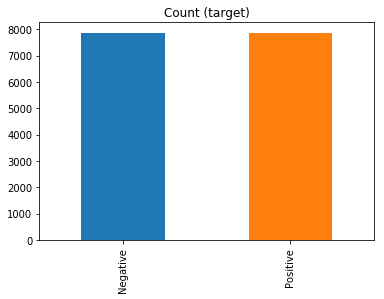

In [14]:
#extract the observations with class zero, equal to the number of obervations equal
df_Sentiment_pos_under = df_Sentiment_pos.sample(count_Sentiment_neg)

#create a new dataframe with the same number of values for our two classes
new_df = pd.concat([df_Sentiment_pos_under, df_Sentiment_neg], axis=0)

print('Random under-sampling:')
print(new_df.Sentiment.value_counts())

new_df.Sentiment.value_counts().plot(kind='bar', title='Count (target)')

In [20]:
#independent and dependent variable

X = new_df.drop(['asin', 'helpful', 'overall', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime',
             'summary', 'reviewText', 'Sentiment'], axis=1)

Y = new_df['Sentiment']

In [21]:
#correlation matrix
print(X.corr())


                   bad    boring       but     worst    wasted    issues  \
bad           1.000000  0.015109  0.075989  0.025532  0.045189  0.047155   
boring        0.015109  1.000000  0.000642 -0.003503 -0.003554  0.011828   
but           0.075989  0.000642  1.000000  0.025095  0.034550  0.053265   
worst         0.025532 -0.003503  0.025095  1.000000  0.040972  0.046450   
wasted        0.045189 -0.003554  0.034550  0.040972  1.000000  0.020917   
issues        0.047155  0.011828  0.053265  0.046450  0.020917  1.000000   
horrible      0.045076  0.020336  0.026836  0.006978  0.006731  0.008417   
embarrassing -0.002210 -0.000484  0.009615 -0.000919 -0.000932 -0.001825   
hated         0.026824  0.036290  0.020141 -0.003186  0.016584  0.034960   
very          0.044521  0.001740  0.120941  0.008553  0.015069  0.054996   
not           0.095177  0.004568  0.298423  0.043301  0.047964  0.055425   
average       0.063449  0.025658  0.069239 -0.000416  0.010318  0.037391   
problem     

AxesSubplot(0.125,0.125;0.62x0.755)


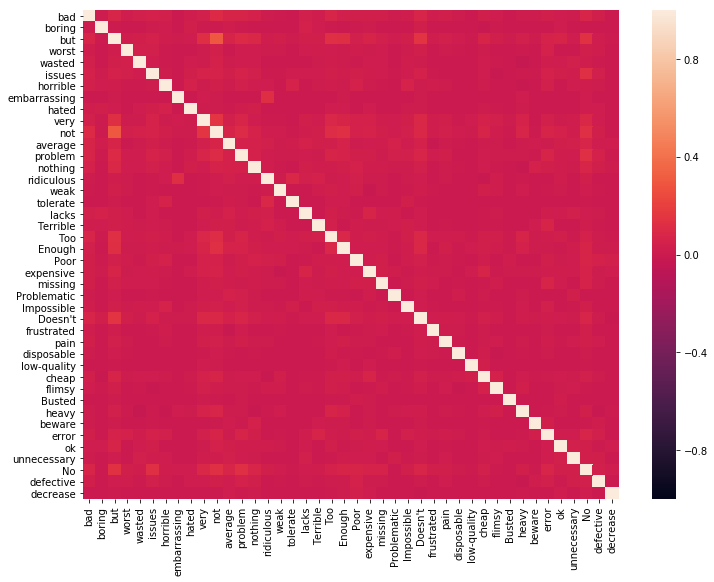

In [22]:
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

#Creating a heatmap to check for any correlation between our independent variables
Xvar_heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1)

print(Xvar_heatmap)

The heatmap above shows that there is no multicollinearity within our independent variables.

In [23]:
#split the data

#splitting the data into train and test groups.

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=.35, random_state=20)
print(test_X.shape)
print(test_Y.shape)

(5511, 42)
(5511,)


# Naive Bayes:

In [24]:
# Instantiate and train our naive bayes model
Mnb = MultinomialNB()

#set start time
start_time = datetime.datetime.now()

# Fit our model to the data.
Mnb.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_bayes = Mnb.predict(test_X)

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y, y_pred_bayes)))

#Run score
print('Score: ', Mnb.score(test_X, test_Y))

#calculate end time
end_time = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time - start_time))
print()

#Use cross validation to gauge the accuracy of our model
Nbayes_cvs = cross_val_score(Mnb, X, Y, cv=10, scoring='accuracy')
print(Nbayes_cvs)
print('Average cross validated score from our Naive Bayes model is: ' + str(np.mean(Nbayes_cvs)))

Accuracy score for decision tree Model: 0.5499909272364362
Score:  0.5499909272364362

Duration: 0:00:00.046904

[0.56535533 0.55076142 0.56925032 0.53748412 0.54510801 0.57115629
 0.56099111 0.55781449 0.53113088 0.51969504]
Average cross validated score from our Naive Bayes model is: 0.5508746992692162


In [25]:
#confusion matrix for naive bayes
from sklearn.metrics import confusion_matrix
confusion_matrix(test_Y, y_pred_bayes)

array([[1612, 1127],
       [1353, 1419]], dtype=int64)

In [26]:
#perform classification report of naive bayes model
class_names = ['Negative', 'Positive']
bayes_report = classification_report(test_Y, y_pred_bayes, target_names=class_names)
print(bayes_report)

              precision    recall  f1-score   support

    Negative       0.54      0.59      0.57      2739
    Positive       0.56      0.51      0.53      2772

   micro avg       0.55      0.55      0.55      5511
   macro avg       0.55      0.55      0.55      5511
weighted avg       0.55      0.55      0.55      5511



In [28]:
# predict probabilities
probs_bayes = Mnb.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_bayes = probs_bayes[:, 1]
# calculate AUC
bayes_auc = roc_auc_score(test_Y, probs_bayes)
print('AUC Score: %.3f' % bayes_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.616


# PCA

In [29]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# o

X_scaled = StandardScaler().fit_transform(X)

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype bool were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [30]:
#Apply PCA

pca = PCA(.95)
X_pca = pca.fit_transform(X_scaled)

comp_no = pca.n_components_
comp_var_ratio = pca.explained_variance_ratio_

print(comp_no)
#print(comp_var_ratio)
#print(p_components)

40


In [31]:
#pca data to dataframe
pca_df = pd.DataFrame(data=X_pca)
print(pca_df.head())
print(pca_df.shape)

         0         1         2         3         4         5         6   \
0  0.157277 -0.654860 -0.098635 -0.157546 -0.004129  0.120089 -0.153675   
1 -1.873776  0.540127  0.058903  0.119883 -0.044861 -0.060073  0.129968   
2  0.750125 -2.334763  0.690406 -0.487271 -0.023640 -0.093094 -1.301555   
3 -1.873776  0.540127  0.058903  0.119883 -0.044861 -0.060073  0.129968   
4  4.100215 -0.242662  0.340549 -1.689948  1.346241  1.787194  0.903959   

         7         8         9     ...           30        31        32  \
0 -0.359403 -0.199715  0.002721    ...    -0.456894  0.838964  0.331247   
1  0.018003  0.090023  0.018825    ...     0.118338 -0.103587  0.064298   
2  0.389711  0.509460 -0.358555    ...    -0.245925 -1.684764 -1.357183   
3  0.018003  0.090023  0.018825    ...     0.118338 -0.103587  0.064298   
4  2.455615 -1.318008 -1.252000    ...    -0.354700 -1.470318  0.414279   

         33        34        35        36        37        38        39  
0 -0.627654  0.139749 -0

With PCA, we were able to reduce our dimensions down to 40, from 42, but still able to explain 95% of the variance in our data.

In [32]:
#After applying PCA, I split the data into a second set of train and test groups

train_X_pca, test_X_pca, train_Y_pca, test_Y_pca = train_test_split(X_pca, Y, test_size=.35, random_state=20)

## Decision Tree

In [33]:
# perform grid search to find the optimal parameters for our decision tree model using pca
dtree_pca = tree.DecisionTreeClassifier(random_state=76)
tree_param_grid_pca = {'max_depth':[2,4,6], 'min_samples_split':[2,5,8], 'max_features':[2,4,6], 'criterion':['entropy', 'gini']}
dtree_grid_pca = GridSearchCV(dtree_pca, tree_param_grid_pca, cv=5, verbose=3)
dtree_grid_pca.fit(train_X_pca, train_Y_pca)
print('Best parameters for decision tree: ', dtree_grid_pca.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5603321934538349, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5891548607718613, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5984367366878358, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5943304007820137, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5953079178885631, total= 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=5, score=0.5943304007820137, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=5 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=5, score=0.5953079178885631, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=8, score=0.5603321934538349, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=8, score=0.5891548607718613, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=8, score=0.5984367366878358, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, m

[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=8, score=0.605276013678554, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=8, score=0.5999022960429897, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=8, score=0.6199316072300928, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=8, score=0.5948191593352884, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=8, score=0.6133919843597263, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, max_features=4, mi

[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, score=0.6121152906692721, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, score=0.6179775280898876, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, score=0.6006842619745846, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=2, score=0.6221896383186706, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=5, score=0.6116267708842208, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=6, max_features=4, m

[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=2, score=0.6055718475073314, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=2, score=0.6119257086999023, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=5, score=0.600390815828041, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=5, score=0.5925744992672203, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=5, score=0.6140693698094772, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=5, score=0.605571

[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, score=0.6165119687347338, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, score=0.5911089399120665, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, score=0.5989252564728872, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, score=0.5894428152492669, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, score=0.5957966764418378, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8 
[CV]  criterio

[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=8, score=0.6041055718475073, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=8 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=8, score=0.6319648093841642, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.6077186126038104, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.6062530532486565, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.6179775280898876, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.59921

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    6.8s finished


In [34]:
print('decision tree best score from Gridsearchcv using pca: ', dtree_grid_pca.best_score_)

decision tree best score from Gridsearchcv using pca:  0.6171210788625037


In [35]:
# Initialize and train our tree using pca
decision_tree_pca = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=2,
    max_depth=6,
    min_samples_split=2,
    random_state = 89
)

#set start time
start_time2 = datetime.datetime.now()

#train our tree
decision_tree_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
y_pred_dtree_pca = decision_tree_pca.predict(test_X_pca)

#Run score
print('Score: ', decision_tree_pca.score(test_X_pca, test_Y_pca))

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y_pca, y_pred_dtree_pca)))

#calculate end time
end_time2 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time2 - start_time2))
print()

#get accuracy score of decision tree
tree_score = cross_val_score(decision_tree_pca, X_pca, Y, cv=10, scoring='accuracy')
print(tree_score)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score)))

Score:  0.6084195245871893
Accuracy score for decision tree Model: 0.6084195245871893

Duration: 0:00:00.031951

[0.58883249 0.61675127 0.60991105 0.64421855 0.62071156 0.61308767
 0.63024142 0.62452351 0.61435832 0.60482846]
Average cross validated score from our decision tree model is: 0.6167464315430311


In [36]:
#confusion matrix for decision tree built with pca
confusion_matrix(test_Y_pca, y_pred_dtree_pca)

array([[2151,  588],
       [1570, 1202]], dtype=int64)

In [37]:
#perform classification report of decicion tree model with PCA
class_names = ['Negative', 'Positive']
tree_report = classification_report(test_Y_pca, y_pred_dtree_pca, target_names=class_names)
print(tree_report)

              precision    recall  f1-score   support

    Negative       0.58      0.79      0.67      2739
    Positive       0.67      0.43      0.53      2772

   micro avg       0.61      0.61      0.61      5511
   macro avg       0.62      0.61      0.60      5511
weighted avg       0.63      0.61      0.60      5511



In [39]:
# predict probabilities
probs_dtree_pca = decision_tree_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_dtree_pca = probs_dtree_pca[:, 1]
# calculate AUC
dtree_pca_auc = roc_auc_score(test_Y_pca, probs_dtree_pca)
print('AUC Score: %.3f' % dtree_pca_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.657


### Decision Tree without PCA

In [40]:
# perform grid search to find the optimal parameters for our decision tree model, but this time using full data
dtree = tree.DecisionTreeClassifier(random_state=76)
tree_param_grid = {'max_depth':[2,4,6], 'min_samples_split':[2,5,8], 'max_features':[2,4,6], 'criterion':['entropy', 'gini']}
dtree_grid = GridSearchCV(dtree, tree_param_grid, cv=5, verbose=3)
dtree_grid.fit(train_X, train_Y)
print('Best parameters for decision tree: ', dtree_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5427454811919883, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5329750854909624, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.537371763556424, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.533724340175953, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=2, score=0.5303030303030303, total=   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=5, score=0.5303030303030303, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=8, score=0.5427454811919883, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=8, score=0.5329750854909624, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=8, score=0.537371763556424, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min_samples_split=8, score=0.533724340175953, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_features=2, min_samples_split=8 
[CV]  criterion=entropy, max_depth=2, max_features=2, min

[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=2, score=0.5730337078651685, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=2, score=0.5525158768930142, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=2, score=0.5622862725940401, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=2, score=0.5601173020527859, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=2, score=0.5728250244379277, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=4, max_features=4, m

[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=5, score=0.5608207132388862, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=5, score=0.5676599902296043, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=5, score=0.5596285434995112, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=5, score=0.5904203323558163, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=8 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=8, score=0.578895945285784, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=8 
[CV]  criterion=entropy, max_depth=6, max_features=4, mi

[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=5, score=0.5366568914956011, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=8 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=8, score=0.5442110405471422, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=8 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=8, score=0.537371763556424, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=8 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=8, score=0.5403028822667318, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=8 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=8, score=0.5420332355816226, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=4, min_samples_split=8 
[CV]  criterion=gini, max_depth=2, max_features=4, min_samples_split=8, score=0.536656

[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, score=0.5728250244379277, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=2, score=0.5339521250610649, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=2, score=0.5300439667806546, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=2, score=0.5417684416218856, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=2, score=0.5303030303030303, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=2, score=0.53225

[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.5412799218368344, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.5666829506595017, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.5547409579667644, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=2, score=0.5845552297165201, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=5, score=0.570591108939912, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=5, score=0.541279

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    5.8s finished


In [41]:
print('decision tree best score from Gridsearchcv: ', dtree_grid.best_score_)

decision tree best score from Gridsearchcv:  0.5732434281246946


In [42]:
# Initialize and train our tree using full data
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_features=4,
    max_depth=6,
    min_samples_split=8,
    random_state = 99
)

#set start time
start_time2 = datetime.datetime.now()

#train our tree
decision_tree.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_dtree = decision_tree.predict(test_X)

#Run score
print('Score: ', decision_tree.score(test_X, test_Y))

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y_pca, y_pred_dtree)))

#calculate end time
end_time2 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time2 - start_time2))
print()

#get accuracy score of decision tree
tree_score = cross_val_score(decision_tree, X, Y, cv=10, scoring='accuracy')
print(tree_score)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score)))

Score:  0.5752132099437489
Accuracy score for decision tree Model: 0.5752132099437489

Duration: 0:00:00.028969

[0.56662437 0.54949239 0.56670902 0.57560356 0.57560356 0.57115629
 0.58259212 0.58767471 0.58005083 0.58513342]
Average cross validated score from our decision tree model is: 0.5740640258257599


In [43]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y, y_pred_dtree)

array([[ 853, 1886],
       [ 455, 2317]], dtype=int64)

In [44]:
#perform classification report of decision tree model with full data
class_names = ['Negative', 'Positive']
tree_report_full = classification_report(test_Y, y_pred_dtree, target_names=class_names)
print(tree_report_full)

              precision    recall  f1-score   support

    Negative       0.65      0.31      0.42      2739
    Positive       0.55      0.84      0.66      2772

   micro avg       0.58      0.58      0.58      5511
   macro avg       0.60      0.57      0.54      5511
weighted avg       0.60      0.58      0.54      5511



In [45]:
# predict probabilities
probs_decision_tree = decision_tree.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_decision_tree = probs_decision_tree[:, 1]
# calculate AUC
decision_tree_auc = roc_auc_score(test_Y, probs_decision_tree)
print('AUC Score: %.3f' % bayes_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.616


In [3]:
# Render our tree.
#tree_data_graph = tree.export_graphviz(
#    decision_tree2, out_file=None,
#    feature_names=X.columns,
#    class_names=['Negative', 'Positive'],
#    filled=True
#)
#graph = pydotplus.graph_from_dot_data(tree_data_graph)
#Image(graph.create_png())

## Random Forest

In [46]:
# perform grid search to find the optimal parameters for our random forest model using full data
rforest = ensemble.RandomForestClassifier(random_state=56)
forest_param_grid = {'n_estimators':[50,100], 'max_depth':[4,6,8], 'min_samples_split':[5,10,15], 
                     'max_features':[4,6,8]}
rforest_grid = GridSearchCV(rforest, forest_param_grid, cv=5, verbose=3)
rforest_grid.fit(train_X, train_Y)



Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6497313141182218, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6150464093795799, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.63019052271617, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6163245356793744, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6392961876832844, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=100, score=0.6482657547630679, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=100, score=0.6155349291646312, total=   0.1s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators=100, score=0.6306790425012213, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=5, n_estimators

[CV]  max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6297020029311187, total=   0.1s
[CV] max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6168132942326491, total=   0.1s
[CV] max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6309872922776149, total=   0.1s
[CV] max_depth=4, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  max_depth=4, max_features=6, min_samples_split=15, n_estimators=50, score=0.6463116756228627, total=   0.0s
[CV] max_depth=4, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  max_depth=4, max_features=6, min_samples_split=15, n_estimators=50, score=0.6189545676599902, total=   0.0s
[CV] max_depth=4, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  max_depth=4, max_features=6, min_samples_split=15, n_e

[CV]  max_depth=6, max_features=4, min_samples_split=5, n_estimators=50, score=0.6199316072300928, total=   0.0s
[CV] max_depth=6, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=4, min_samples_split=5, n_estimators=50, score=0.6311675622862726, total=   0.0s
[CV] max_depth=6, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=4, min_samples_split=5, n_estimators=50, score=0.6182795698924731, total=   0.0s
[CV] max_depth=6, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=4, min_samples_split=5, n_estimators=50, score=0.6378299120234604, total=   0.0s
[CV] max_depth=6, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, max_features=4, min_samples_split=5, n_estimators=100, score=0.6492427943331704, total=   0.1s
[CV] max_depth=6, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, max_features=4, min_samples_split=5, n_estimators=100

[CV]  max_depth=6, max_features=6, min_samples_split=10, n_estimators=100, score=0.6507083536883244, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=10, n_estimators=100, score=0.6228627259404006, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=10, n_estimators=100, score=0.6331216414264778, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=10, n_estimators=100, score=0.6168132942326491, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=10, n_estimators=100, score=0.6339198435972629, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  max_depth=6, max_features=6, min_samples_split=15,

[CV]  max_depth=6, max_features=8, min_samples_split=15, n_estimators=100, score=0.6300097751710655, total=   0.1s
[CV] max_depth=8, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=4, min_samples_split=5, n_estimators=50, score=0.6487542745481192, total=   0.0s
[CV] max_depth=8, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=4, min_samples_split=5, n_estimators=50, score=0.621885686370298, total=   0.0s
[CV] max_depth=8, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=4, min_samples_split=5, n_estimators=50, score=0.6316560820713238, total=   0.0s
[CV] max_depth=8, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=4, min_samples_split=5, n_estimators=50, score=0.6173020527859238, total=   0.0s
[CV] max_depth=8, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=4, min_samples_split=5, n_estimators=50, s

[CV]  max_depth=8, max_features=6, min_samples_split=10, n_estimators=50, score=0.6197458455522972, total=   0.0s
[CV] max_depth=8, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, max_features=6, min_samples_split=10, n_estimators=50, score=0.6397849462365591, total=   0.0s
[CV] max_depth=8, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, max_features=6, min_samples_split=10, n_estimators=100, score=0.6570591108939912, total=   0.1s
[CV] max_depth=8, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, max_features=6, min_samples_split=10, n_estimators=100, score=0.6243282852955545, total=   0.1s
[CV] max_depth=8, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, max_features=6, min_samples_split=10, n_estimators=100, score=0.6297020029311187, total=   0.1s
[CV] max_depth=8, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, max_features=6, min_samples_split=10, n

[CV]  max_depth=8, max_features=8, min_samples_split=15, n_estimators=100, score=0.6316560820713238, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_split=15, n_estimators=100 
[CV]  max_depth=8, max_features=8, min_samples_split=15, n_estimators=100, score=0.6231671554252199, total=   0.1s
[CV] max_depth=8, max_features=8, min_samples_split=15, n_estimators=100 
[CV]  max_depth=8, max_features=8, min_samples_split=15, n_estimators=100, score=0.636852394916911, total=   0.1s


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   51.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=56, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100], 'max_depth': [4, 6, 8], 'min_samples_split': [5, 10, 15], 'max_features': [4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [47]:
print('Best parameters for random forest: ', rforest_grid.best_params_)
print('Best score for random forest: ', rforest_grid.best_score_)

Best parameters for random forest:  {'max_depth': 8, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 50}
Best score for random forest:  0.6357861819603244


In [48]:
#initialize and train our random forest model using full data
rand_forest = ensemble.RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=8, max_features=6,
                                              min_samples_split=5, random_state=109)

#set start time
start_time3 = datetime.datetime.now()

rand_forest.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_rforest = rand_forest.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y, y_pred_rforest)))

#calculate end time
end_time3 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time3 - start_time3))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs = cross_val_score(rand_forest, X, Y, cv=5, scoring='accuracy')
print(rforest_cvs)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_cvs)))

Accuracy score for Random Forest Model: 0.6358192705498095

Duration: 0:00:00.158077

[0.59428571 0.6384127  0.63818297 0.65120712 0.65088945]
Average cross validated score from our Random Forest Model is: 0.6345955910530244


In [49]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y, y_pred_rforest)

array([[2060,  679],
       [1328, 1444]], dtype=int64)

In [50]:
#perform classification report of random forest classifier model with full data
class_names = ['Negative', 'Positive']
rforest_report = classification_report(test_Y, y_pred_rforest, target_names=class_names)
print(rforest_report)

              precision    recall  f1-score   support

    Negative       0.61      0.75      0.67      2739
    Positive       0.68      0.52      0.59      2772

   micro avg       0.64      0.64      0.64      5511
   macro avg       0.64      0.64      0.63      5511
weighted avg       0.64      0.64      0.63      5511



In [51]:
# predict probabilities
probs_rforest = rand_forest.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_rforest = probs_rforest[:, 1]
# calculate AUC
rforest_auc = roc_auc_score(test_Y, probs_rforest)
print('AUC Score: %.3f' % rforest_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.691


In [52]:
# perform grid search to find the optimal parameters for our random forest model using pca
rforest_pca = ensemble.RandomForestClassifier(random_state=117)
forest_param_grid_pca = {'n_estimators':[50,100], 'max_depth':[4,6,8], 'min_samples_split':[5,10,15], 
                     'max_features':[4,6,8], 'criterion':['gini', 'entropy']}
rforest_grid_pca = GridSearchCV(rforest_pca, forest_param_grid_pca, cv=5, verbose=3)
rforest_grid_pca.fit(train_X_pca, train_Y_pca)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6370297997068881, total=   0.1s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6145578895945286, total=   0.1s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.638495359062042, total=   0.1s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6197458455522972, total=   0.1s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.626099706744868, total=   0.1s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=100, score=0.6350757205666829, total=   0.3s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=5, n_estimators=100, score=0.6189545676599902, total=   0.3s
[

[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50, score=0.6360527601367856, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50, score=0.6213971665852467, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50, score=0.6375183194919394, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50, score=0.6163245356793744, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=50, score=0.6202346041055719, total=  

[CV]  criterion=gini, max_depth=4, max_features=8, min_samples_split=10, n_estimators=100, score=0.6192570869990225, total=   0.5s
[CV] criterion=gini, max_depth=4, max_features=8, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=8, min_samples_split=10, n_estimators=100, score=0.6319648093841642, total=   0.5s
[CV] criterion=gini, max_depth=4, max_features=8, min_samples_split=15, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=8, min_samples_split=15, n_estimators=50, score=0.633610161211529, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=8, min_samples_split=15, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=8, min_samples_split=15, n_estimators=50, score=0.6165119687347338, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=8, min_samples_split=15, n_estimators=50 
[CV]  criterion=gini, max_depth=4, max_features=8, min_samples_split=15, n_estimators=50, score=0.6360527601367856, total=

[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=15, n_estimators=100, score=0.63019052271617, total=   0.4s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=15, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=15, n_estimators=100, score=0.6380068392769908, total=   0.4s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=15, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=15, n_estimators=100, score=0.6129032258064516, total=   0.4s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=15, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=15, n_estimators=100, score=0.6402737047898338, total=   0.4s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=5, n_estimators=50 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=5, n_estimators=50, score=0.6297020029311187, total

[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=50, score=0.636852394916911, total=   0.3s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100, score=0.6399609184171959, total=   0.7s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100, score=0.6257938446507083, total=   0.7s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100, score=0.6355642403517342, total=   0.7s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=5, n_estimators=100, score=0.6143695014662757, total=   0

[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=50, score=0.6306790425012213, total=   0.2s
[CV] criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=50, score=0.6212121212121212, total=   0.2s
[CV] criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=50 
[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=50, score=0.6339198435972629, total=   0.2s
[CV] criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=100, score=0.6355642403517342, total=   0.5s
[CV] criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=10, n_estimators=100, score=0.6174890083048363, tota

[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50, score=0.6380068392769908, total=   0.3s
[CV] criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50, score=0.6199316072300928, total=   0.3s
[CV] criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50, score=0.63019052271617, total=   0.3s
[CV] criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50, score=0.6256109481915934, total=   0.3s
[CV] criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50 
[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=15, n_estimators=50, score=0.6348973607038123, total=   0

[CV]  criterion=gini, max_depth=8, max_features=8, min_samples_split=15, n_estimators=100, score=0.6217008797653959, total=   0.9s
[CV] criterion=gini, max_depth=8, max_features=8, min_samples_split=15, n_estimators=100 
[CV]  criterion=gini, max_depth=8, max_features=8, min_samples_split=15, n_estimators=100, score=0.635386119257087, total=   0.9s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6340986809965804, total=   0.1s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.6101612115290669, total=   0.1s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=5, n_estimators=50, score=0.635075720566

[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100, score=0.6311675622862726, total=   0.5s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100, score=0.621885686370298, total=   0.6s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100, score=0.6375183194919394, total=   0.6s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100, score=0.6124144672531769, total=   0.6s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=5, n_estimators=100, score=0.

[CV]  criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=50, score=0.6360527601367856, total=   0.3s
[CV] criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=50 
[CV]  criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=50, score=0.6202346041055719, total=   0.3s
[CV] criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=50 
[CV]  criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=50, score=0.6334310850439883, total=   0.3s
[CV] criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=100, score=0.6321446018563752, total=   0.7s
[CV] criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=8, min_samples_split=10, n_estimators=100, sco

[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=10, n_estimators=100, score=0.6397849462365591, total=   0.5s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50, score=0.626770884220811, total=   0.2s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50, score=0.6287249633610161, total=   0.2s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50, score=0.6375183194919394, total=   0.2s
[CV] criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50 
[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=15, n_estimators=50, score=0

[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=15, n_estimators=100, score=0.6248168050806058, total=   0.8s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=15, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=15, n_estimators=100, score=0.6326331216414265, total=   0.8s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=15, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=15, n_estimators=100, score=0.6236559139784946, total=   0.8s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=15, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=15, n_estimators=100, score=0.6392961876832844, total=   0.8s
[CV] criterion=entropy, max_depth=6, max_features=8, min_samples_split=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=6, max_features=8, min_samples_split=5, n_estimators=50, sc

[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=50, score=0.6217008797653959, total=   0.3s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=50, score=0.6402737047898338, total=   0.3s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=100, score=0.6340986809965804, total=   0.7s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=100, score=0.6243282852955545, total=   0.7s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=5, n_estimators=100, score=0.63

[CV]  criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50, score=0.6399609184171959, total=   0.4s
[CV] criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50, score=0.6179775280898876, total=   0.4s
[CV] criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50, score=0.6355642403517342, total=   0.4s
[CV] criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50, score=0.6226783968719453, total=   0.4s
[CV] criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=6, min_samples_split=10, n_estimators=50, score=0

[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=100, score=0.6297020029311187, total=   1.3s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=100, score=0.6236559139784946, total=   1.3s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=100, score=0.635386119257087, total=   1.3s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=15, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=15, n_estimators=50, score=0.6365412799218368, total=   0.6s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=15, n_estimators=50 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=15, n_estimators=50, sco

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  5.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=117, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100], 'max_depth': [4, 6, 8], 'min_samples_split': [5, 10, 15], 'max_features': [4, 6, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [53]:
print('Best parameters for random forest with pca: ', rforest_grid_pca.best_params_)
print('Best score for random forest with pca: ', rforest_grid_pca.best_score_)

Best parameters for random forest with pca:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 4, 'min_samples_split': 15, 'n_estimators': 100}
Best score for random forest with pca:  0.6335385517443565


In [54]:
#initialize and train our random forest model using pca
rand_forest_pca = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=6, max_features=4,
                                              min_samples_split=15, random_state=219)

#set start time
start_time3 = datetime.datetime.now()

rand_forest_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
y_pred_rforest_pca = rand_forest_pca.predict(test_X_pca)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y_pca, y_pred_rforest_pca)))

#calculate end time
end_time3 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time3 - start_time3))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs_pca = cross_val_score(rand_forest_pca, X_pca, Y, cv=5, scoring='accuracy')
print(rforest_cvs_pca)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_cvs_pca)))

Accuracy score for Random Forest Model: 0.6372709127200146

Duration: 0:00:00.614212

[0.60634921 0.63333333 0.63659466 0.64866582 0.64167726]
Average cross validated score from our Random Forest Model is: 0.6333240555858091


In [55]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y_pca, y_pred_rforest_pca)

array([[2027,  712],
       [1287, 1485]], dtype=int64)

In [56]:
#perform classification report of random forest classifier model with pca
class_names = ['Negative', 'Positive']
forest_report_pca = classification_report(test_Y_pca, y_pred_rforest_pca, target_names=class_names)
print(forest_report_pca)

              precision    recall  f1-score   support

    Negative       0.61      0.74      0.67      2739
    Positive       0.68      0.54      0.60      2772

   micro avg       0.64      0.64      0.64      5511
   macro avg       0.64      0.64      0.63      5511
weighted avg       0.64      0.64      0.63      5511



In [57]:
# predict probabilities
probs_rforest_pca = rand_forest_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_rforest_pca = probs_rforest_pca[:, 1]
# calculate AUC
rforest_pca_auc = roc_auc_score(test_Y_pca, probs_rforest_pca)
print('AUC Score: %.3f' % rforest_pca_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.687


# Gradient Boosting

In [58]:
start_time6 = datetime.datetime.now()
#Run gridsearchcv to find the best parameters for gradient boosting.
gboost_param_grid = {'n_estimators':[200,300], 'max_depth':[4,6,8], 'min_samples_split': [5,10,15], 
                     'learning_rate': [.05, .02, .01], 'subsample': [.7, .8, .9]}
gb_model = ensemble.GradientBoostingClassifier()

gb_grid = GridSearchCV(gb_model, gboost_param_grid, cv=5, verbose=3)
gb_grid.fit(train_X, train_Y)
print('Best parameters for decision tree:', gb_grid.best_params_)
print('Best score for gradient boosting model: ', gb_grid.best_score_)
print()
#calculate end time
end_time6 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time6 - start_time6))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6487542745481192, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6238397655105031, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6389838788470933, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6304985337243402, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6441837732160313, total=   1.8s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6507083536883244, total=   1.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200, subsample=0.8, score=0

[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6427174975562072, total=   1.8s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6541279921836834, total=   1.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.625305324865657, total=   1.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6404494382022472, total=   1.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.9,

[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6238397655105031, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6331216414264778, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6314760508308895, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6432062561094819, total=   2.7s
[CV] learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_split=15, n_estimators=300, subsample=0.8

[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.6231671554252199, total=   4.8s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.635386119257087, total=   4.7s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6497313141182218, total=   4.7s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6194430874450415, total=   4.7s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.

[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.646800195407914, total=   3.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6248168050806058, total=   3.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6331216414264778, total=   3.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6275659824046921, total=   2.9s
[CV] learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_split=15, n_estimators=200, subsample=0.7,

[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6248168050806058, total=   4.9s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6192570869990225, total=   4.8s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.8, score=0.6358748778103617, total=   4.8s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.6428920371275036, total=   4.8s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.9, score=0

[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6402737047898338, total=   4.4s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6321446018563752, total=   6.7s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6062530532486565, total=   6.9s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6160234489496824, total=   6.9s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.7

[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6116267708842208, total=   6.6s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6204201270151442, total=   6.6s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6173020527859238, total=   6.6s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.8, score=0.6334310850439883, total=   6.5s
[CV] learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=8, min_samples_split=15, n_estimators=300, subsample=0.9

[CV]  learning_rate=0.02, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6265884652981427, total=   2.8s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.6402737047898338, total=   2.8s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.6526624328285295, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.6238397655105031, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=10, n_estimators=200, subsample=0.7, s

[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.651685393258427, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.6233512457254519, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.633610161211529, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, score=0.6231671554252199, total=   2.0s
[CV] learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_split=15, n_estimators=200, subsample=0.8, 

[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.6380068392769908, total=   3.6s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.626099706744868, total=   3.5s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.9, score=0.6436950146627566, total=   3.6s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.6570591108939912, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.

[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.7, score=0.6427174975562072, total=   4.7s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.6502198339032731, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.618466047874939, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.6380068392769908, total=   4.8s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=10, n_estimators=300, subsample=0.8,

[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6223742061553493, total=   4.9s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6350757205666829, total=   4.9s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6300097751710655, total=   4.7s
[CV] learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.9, score=0.6441837732160313, total=   4.8s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=5, n_estimators=200, subsample=0.7, 

[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.626099706744868, total=   4.5s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.7, score=0.6451612903225806, total=   4.5s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6497313141182218, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6170004885197851, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=10, n_estimators=200, subsample=0.8,

[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6502198339032731, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6213971665852467, total=   5.0s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6370297997068881, total=   5.1s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9, score=0.6295210166177908, total=   4.9s
[CV] learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.9

[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.6326331216414265, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.6217008797653959, total=   3.1s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.7, score=0.636852394916911, total=   3.1s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.651685393258427, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.6

[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.8, score=0.6388074291300098, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6507083536883244, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6213971665852467, total=   3.2s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6306790425012213, total=   3.3s
[CV] learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_split=10, n_estimators=300, subsample=0.9

[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6213971665852467, total=   3.6s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6311675622862726, total=   3.6s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6251221896383187, total=   3.5s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.7, score=0.6348973607038123, total=   3.6s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=5, n_estimators=200, subsample=0.8, score=0

[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6236559139784946, total=   3.7s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.8, score=0.6348973607038123, total=   3.7s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6531509526135808, total=   3.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9, score=0.6194430874450415, total=   3.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=10, n_estimators=200, subsample=0.9

[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6555935515388374, total=   4.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6233512457254519, total=   4.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6409379579872985, total=   5.0s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7, score=0.6285434995112414, total=   4.9s
[CV] learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_split=15, n_estimators=300, subsample=0.7

[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.6380068392769908, total=   8.2s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.624633431085044, total=   8.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.8, score=0.64613880742913, total=   8.0s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.646800195407914, total=   8.5s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=5, n_estimators=300, subsample=0.9, score=0.617

[CV]  learning_rate=0.01, max_depth=8, min_samples_split=10, n_estimators=300, subsample=0.9, score=0.6471163245356794, total=   8.1s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6531509526135808, total=   4.7s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6209086468001954, total=   4.8s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7, score=0.6355642403517342, total=   4.8s
[CV] learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_split=15, n_estimators=200, subsample=0.7

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 59.5min finished


Best parameters for decision tree: {'learning_rate': 0.02, 'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best score for gradient boosting model:  0.6391087657578423


Duration: 0:59:36.492488


In [59]:
# Initialize and fit the model.
Grad_boost = ensemble.GradientBoostingClassifier(learning_rate=0.02, max_depth=6, min_samples_split=5, 
                                                 n_estimators=200, subsample=0.8, random_state=314)

#set start time
start_time5 = datetime.datetime.now()

#fit and train the model
Grad_boost.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_Gboost = Grad_boost.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Gradient Boosting Model: ' + str(metrics.accuracy_score(test_Y, y_pred_Gboost)))

#calculate end time
end_time5 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time5 - start_time5))
print()

#get average accuracy score using cross validation
Grad_boost_cvs = cross_val_score(Grad_boost, X, Y, cv=5, scoring='accuracy')
print(Grad_boost_cvs)

print('Average cross validated score from our Gradient Boosting model is: ' + str(np.mean(Grad_boost_cvs)))

Accuracy score for Gradient Boosting Model: 0.6378152785338415

Duration: 0:00:04.567008

[0.61111111 0.64095238 0.63850064 0.64771283 0.64675985]
Average cross validated score from our Gradient Boosting model is: 0.6370073616909704


In [65]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y, y_pred_Gboost)

array([[   90,  2644],
       [   80, 15666]], dtype=int64)

In [64]:
#perform classification report of Gradient Boosting model with full data
class_names = ['Negative', 'Positive']
Gboost_report = classification_report(test_Y, y_pred_Gboost, target_names=class_names)
print(Gboost_report)

              precision    recall  f1-score   support

    Negative       0.61      0.75      0.67      2739
    Positive       0.68      0.52      0.59      2772

   micro avg       0.64      0.64      0.64      5511
   macro avg       0.65      0.64      0.63      5511
weighted avg       0.65      0.64      0.63      5511



In [66]:
# predict probabilities
probs_gboost = Grad_boost.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_gboost = probs_gboost[:, 1]
# calculate AUC
gboost_auc = roc_auc_score(test_Y, probs_gboost)
print('AUC Score: %.3f' % gboost_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_gboost)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.692


In [67]:
# Initialize and fit the model using pca
Grad_boost_pca = ensemble.GradientBoostingClassifier(learning_rate=0.02, max_depth=6, min_samples_split=5, 
                                                 n_estimators=200, subsample=0.8, random_state=314)

#set start time
start_time5 = datetime.datetime.now()

#fit and train the model
Grad_boost_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
y_pred_Gboost_pca = Grad_boost_pca.predict(test_X_pca)

#get accuracy score from our model
print('Accuracy score for Gradient Boosting Model using pca: ' + str(metrics.accuracy_score(test_Y_pca, y_pred_Gboost_pca)))

#calculate end time
end_time5 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time5 - start_time5))
print()

#get average accuracy score using cross validation
Grad_boost_pca_cvs = cross_val_score(Grad_boost_pca, X_pca, Y, cv=5, scoring='accuracy')
print(Grad_boost_pca_cvs)

print('Average cross validated score from our Gradient Boosting model is: ' + str(np.mean(Grad_boost_pca_cvs)))

Accuracy score for Gradient Boosting Model using pca: 0.63454908365088

Duration: 0:00:19.096455

[0.60920635 0.63492063 0.63564168 0.64898348 0.63786531]
Average cross validated score from our Gradient Boosting model is: 0.633323490853351


In [68]:
#confusion matrix for decision tree built on full data
confusion_matrix(test_Y_pca, y_pred_Gboost_pca)

array([[1948,  791],
       [1223, 1549]], dtype=int64)

In [69]:
#perform classification report of Gradient Boosting model with full data
class_names = ['Negative', 'Positive']
Gboost_report_pca = classification_report(test_Y_pca, y_pred_Gboost_pca, target_names=class_names)
print(Gboost_report_pca)

              precision    recall  f1-score   support

    Negative       0.61      0.71      0.66      2739
    Positive       0.66      0.56      0.61      2772

   micro avg       0.63      0.63      0.63      5511
   macro avg       0.64      0.64      0.63      5511
weighted avg       0.64      0.63      0.63      5511



In [70]:
# predict probabilities
probs_gboost_pca = Grad_boost_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_gboost_pca = probs_gboost_pca[:, 1]
# calculate AUC
gboost_pca_auc = roc_auc_score(test_Y_pca, probs_gboost_pca)
print('AUC Score: %.3f' % gboost_pca_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.684


# Logistic Regression

In [71]:
#initialize and train our model with full data
LogReg = LogisticRegression(C=1e9, random_state=412)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_LogReg = LogReg.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y, y_pred_LogReg)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs = cross_val_score(LogReg, X, Y, cv=5, scoring='accuracy')
print(LogReg_cvs)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model: 0.6432589366721103

Duration: 0:00:00.162408



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

[0.59809524 0.63904762 0.64072427 0.64961881 0.64580686]
Average cross validated score from our log regression model is: 0.6346585587220911


In [72]:
#confusion matrix for logistic regression on full data
confusion_matrix(test_Y, y_pred_LogReg)

array([[1807,  932],
       [1034, 1738]], dtype=int64)

In [73]:
#perform classification report of logistic regression model with full data
class_names = ['Negative', 'Positive']
LogReg_report = classification_report(test_Y, y_pred_LogReg, target_names=class_names)
print(LogReg_report)

              precision    recall  f1-score   support

    Negative       0.64      0.66      0.65      2739
    Positive       0.65      0.63      0.64      2772

   micro avg       0.64      0.64      0.64      5511
   macro avg       0.64      0.64      0.64      5511
weighted avg       0.64      0.64      0.64      5511



In [74]:
# predict probabilities
probs_LogReg = LogReg.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_LogReg = probs_LogReg[:, 1]
# calculate AUC
LogReg_auc = roc_auc_score(test_Y, probs_LogReg)
print('AUC Score: %.3f' % LogReg_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.696


In [75]:
#initialize and train our model with pca
LogReg_pca = LogisticRegression(C=1e9, random_state=412)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
y_pred_LogReg_pca = LogReg_pca.predict(test_X_pca)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model using pca: ' + str(metrics.accuracy_score(test_Y_pca, y_pred_LogReg_pca)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs_pca = cross_val_score(LogReg_pca, X_pca, Y, cv=5, scoring='accuracy')
print(LogReg_cvs_pca)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs_pca)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model using pca: 0.6425331155870078

Duration: 0:00:00.099036



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.59587302 0.64       0.64199492 0.64675985 0.64644219]
Average cross validated score from our log regression model is: 0.6342139932635485


In [76]:
#confusion matrix for logistic regression model with pca
confusion_matrix(test_Y_pca, y_pred_LogReg_pca)

array([[1686, 1053],
       [ 917, 1855]], dtype=int64)

In [77]:
#perform classification report of logistic regression model with pca
class_names = ['Negative', 'Positive']
LogReg_report_pca = classification_report(test_Y_pca, y_pred_LogReg_pca, target_names=class_names)
print(LogReg_report_pca)

              precision    recall  f1-score   support

    Negative       0.65      0.62      0.63      2739
    Positive       0.64      0.67      0.65      2772

   micro avg       0.64      0.64      0.64      5511
   macro avg       0.64      0.64      0.64      5511
weighted avg       0.64      0.64      0.64      5511



In [78]:
# predict probabilities
probs_LogReg_pca = LogReg_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_LogReg_pca = probs_LogReg_pca[:, 1]
# calculate AUC
LogReg_pca_auc = roc_auc_score(test_Y_pca, probs_LogReg_pca)
print('AUC Score: %.3f' % LogReg_pca_auc)
# calculate roc curve
#fpr_bayes, tpr_bayes, thresholds = roc_curve(test_Y, probs_bayes)
# plot no skill
#plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.plot(fpr_bayes, tpr_bayes, marker='.')
# show the plot
#plt.show()

AUC Score: 0.695


# KNN Classifier:

In [79]:
# perform grid search to find the optimal parameters for our KNN model, using full data.
KNN = KNeighborsClassifier()
param_grid = {'n_neighbors':[5,10,15], 'weights':['uniform', 'distance']}
KNN_grid = GridSearchCV(KNN, param_grid, cv=5, verbose=3)
KNN_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=5, weights=uniform, score=0.6018563751831949, total=   2.0s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV]  n_neighbors=5, weights=uniform, score=0.5896433805569126, total=   2.0s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.2s remaining:    0.0s


[CV]  n_neighbors=5, weights=uniform, score=0.6140693698094772, total=   2.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.5913978494623656, total=   2.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.613880742913001, total=   2.0s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.6047874938935027, total=   2.1s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.5950170981924768, total=   1.9s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.6077186126038104, total=   2.0s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.5889540566959922, total=   2.1s
[CV] n_neighbors=5, weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [80]:
print('Best parameters for data:', KNN_grid.best_params_)

Best parameters for data: {'n_neighbors': 10, 'weights': 'uniform'}


In [81]:
#initialize and train our model using the training set and full data
KNN = KNeighborsClassifier(n_neighbors=10, weights='uniform')

#set start time
start_time6 = datetime.datetime.now()

#fit and train the model
KNN.fit(train_X,train_Y)

#Make predictions using test_X, and store results in new variable
y_pred_KNN = KNN.predict(test_X)

print('Accuracy score for KNN Model: ' + str(metrics.accuracy_score(test_Y, y_pred_KNN)))

#calculate end time
end_time6 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time6 - start_time6))
print()


KNN_cvs = cross_val_score(KNN, X, Y, cv=5, scoring='accuracy')
print(KNN_cvs)
print('Average cross validated score from our KNN model is: ' + str(np.mean(KNN_cvs)))


Accuracy score for KNN Model: 0.619851206677554

Duration: 0:00:06.453221

[0.52761905 0.53365079 0.53017789 0.53811944 0.53716645]
Average cross validated score from our KNN model is: 0.5333467255601944


In [82]:
#confusion matrix for KNN built on full data
confusion_matrix(test_Y, y_pred_KNN)

array([[1840,  899],
       [1196, 1576]], dtype=int64)

In [83]:
#perform classification report of Knn with full data
class_names = ['Negative', 'Positive']
Knn_report = classification_report(test_Y, y_pred_KNN, target_names=class_names)
print(Knn_report)

              precision    recall  f1-score   support

    Negative       0.61      0.67      0.64      2739
    Positive       0.64      0.57      0.60      2772

   micro avg       0.62      0.62      0.62      5511
   macro avg       0.62      0.62      0.62      5511
weighted avg       0.62      0.62      0.62      5511

